In [1]:
# %load_ext autoreload
# %autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append('../')

from matplotlib.colors import LogNorm
from src.viz import plot_trajectories, use_mpl_scatter_density, plot_transition_matrix,plot_implied_timescales
from src.io import load_dataframe, save_dataframe
from src.preprocessing import (compute_phases,split_trajectories,filter_trajectories,smooth_trajectory_savgol)
from src.embedding import Embedding
from src.embedding_position import EmbeddingPosition
from umap import UMAP
from src.preprocessing import reconstruct_trajectory_from_angles

from scipy.spatial import Voronoi, voronoi_plot_2d


In [2]:
df = pd.read_parquet('../data/toy_model/interim/phases.parquet')
print(df.shape)
df.head()

(9970, 9)


,x,y,z,label,frame,speed,curvature_angle,torsion_angle,abs_torsion_angle
0,-0.880313,-0.686254,0.883615,1,1,1.567489,0.965899,1.299239,1.299239
1,-0.949319,-0.417317,2.383158,1,2,1.617988,0.514461,-0.389328,0.389328
2,-1.425018,0.566557,3.699607,1,3,1.209617,0.651081,1.418937,1.418937
3,-1.598190,1.231231,3.872498,1,4,0.770960,0.665557,-0.346111,0.346111
4,-2.236158,1.767626,3.857619,1,5,0.578744,2.629353,-2.789577,2.789577


/mnt/hcleroy/anaconda3/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/mnt/hcleroy/anaconda3/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


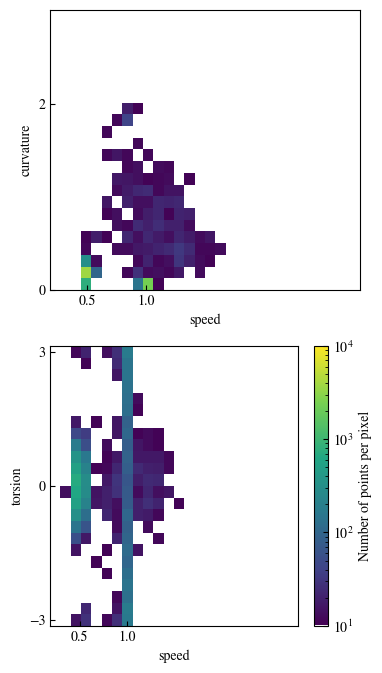

In [3]:
#plt.scatter(df[df['label'] ==1]['speed'],df[df['label'] ==1]['curvature_angle'],marker='o',alpha=0.1)
fig = plt.figure(figsize=(4,8))
norm = LogNorm(vmin=1e1,vmax=10**4)
ax1 = use_mpl_scatter_density(fig, df['speed'],df['curvature_angle'],dpi=10,norm=norm,nrows=2,pos=1,colorbar=None)
ax1.set_xlabel('speed')
ax1.set_ylabel('curvature')
ax1.set_xticks([0.5,1.])
ax1.set_yticks([0.,2.])
#ax1.grid()
ax2 = use_mpl_scatter_density(fig, df['speed'],df['torsion_angle'],dpi=10,norm=norm,nrows=2,pos=2)
ax2.set_xlabel('speed')
ax2.set_ylabel('torsion')
ax2.set_xticks([0.5,1])
ax2.set_yticks([-3,0,3])
#ax2.grid()
#fig.savefig('phase_space_toy_model.svg',transparent=True,bbox_inches='tight')

In [4]:
#emb = Embedding(df,
#                columns=['speed','curvature_angle','abs_torsion_angle'],
#                ID_NAME='label')
emb = EmbeddingPosition(df,columns=['speed'],columns_translated=['x','y','z'],ID_NAME='label')
#emb = Embedding(df,
#                columns=['speed','curvature_angle'],ID_NAME='label')

In [21]:
emb.make_embedding(K=20)

(array([[[ 1.56748881e+00, -4.33662231e+00,  3.93400660e-01, ...,
           5.07599549e+00,  1.63705922e+00, -4.31442047e-01],
         [ 1.61798825e+00, -3.16364099e+00,  9.42827072e-01, ...,
           4.14016213e+00,  1.19481055e+00, -3.60956099e-01],
         [ 1.20961687e+00, -2.04104944e+00,  2.68669028e-01, ...,
           4.09661351e+00,  4.38981368e-01,  7.23886094e-02],
         ...,
         [ 5.00632615e-01,  3.02200458e+00,  1.85497912e+00, ...,
          -3.05030179e+00,  1.86219306e+00, -7.79173898e-02],
         [ 5.08610174e-01,  3.04827094e+00,  1.85139847e+00, ...,
          -3.03623739e+00,  1.88467529e+00, -1.08458144e-01],
         [ 5.00840743e-01,  3.05775848e+00,  1.85119222e+00, ...,
          -3.02308641e+00,  1.88209357e+00, -1.30721396e-01]],
 
        [[ 1.02670084e+00, -9.49047617e+00, -1.76725715e-02, ...,
           9.48405545e+00,  3.37846572e-02, -1.64728389e-02],
         [ 9.92720909e-01,  9.48339095e+00,  6.47328108e-04, ...,
          -9.47244562

In [22]:
emb.make_cluster(5,clustering_method='kmeans')#,n_subsample=1000)

array([1, 1, 1, ..., 2, 2, 2], dtype=int32)

In [23]:
# Label the rest by nearest center
from scipy.spatial.distance import cdist
dists = cdist(emb.flatten_embedding_matrix, emb.cluster_centers_, metric='euclidean')
emb.labels = np.argmin(dists, axis=1)
#self.cluster_centers_ = centers
#return self.labels

0
0


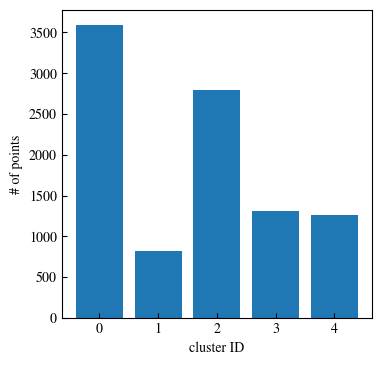

In [24]:
# look at the distribution of points in the clusters
unique_labels, counts = np.unique(emb.labels, return_counts=True)
# Optionally, zip into a dict
cluster_counts = dict(zip(unique_labels, counts))
fig,ax = plt.subplots(figsize=(4,4))
ax.bar(list(cluster_counts.keys()),list(cluster_counts.values()))
ax.set_xlabel('cluster ID')
ax.set_ylabel('# of points')
print(unique_labels[np.argmax(counts)])
print(np.argmax(counts))

In [25]:
rng = np.random.default_rng(10973)
print(emb.flatten_embedding_matrix.shape[0])
indices = rng.choice(emb.flatten_embedding_matrix.shape[0], size=9680, replace=False)
data = emb.flatten_embedding_matrix[indices]
    
combined =np.array([])
# Concatenate data and centers before UMAP
combined = np.append(data, emb.cluster_centers_, axis=0)

9780


In [26]:
reducer = UMAP(
        n_neighbors=10,
        min_dist=0.5,
        n_components=2,
        metric="euclidean",
    )
reduced_all = reducer.fit_transform(combined)

In [27]:
N = data.shape[0]
reduced_points = reduced_all[:N]
reduced_centers = reduced_all[N:N + emb.cluster_centers_.shape[0]]

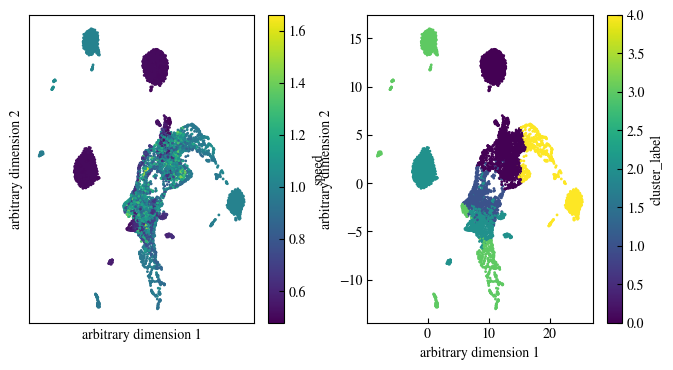

In [31]:
fig,ax = plt.subplots(ncols=2,figsize=(8,4))

#speedx = emb.flatten_embedding_matrix[indices,0::3][:,1:] - emb.flatten_embedding_matrix[indices,0::3][:,:-1]
#speedy = emb.flatten_embedding_matrix[indices,1::3][:,1:] - emb.flatten_embedding_matrix[indices,1::3][:,:-1]
#speedz = emb.flatten_embedding_matrix[indices,2::3][:,1:] - emb.flatten_embedding_matrix[indices,2::3][:,:-1]
#speed = np.mean(np.linalg.norm(np.array([speedx,speedy,speedz]).T,axis=2),axis=0)
#print(speed.shape)
#color_values=speed
color_values = np.mean(emb.flatten_embedding_matrix[indices, 0::4], axis=1)
sc = ax[0].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1,rasterized=True)
#ax = use_mpl_scatter_density(fig, reduced_points[:,0],reduced_points[:,1],dpi=10,nrows=1,pos=1,colorbar=None)
#for i in range(reduced_centers.shape[0]):
#    ax.scatter(reduced_centers[i,0],reduced_centers[i,1],s=counts[i]*0.01,color="red", alpha=0.3)
    
vor = Voronoi(reduced_centers)
#voronoi_plot_2d(vor, ax=ax[0], show_points = False, show_vertices=False, line_colors='red')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('arbitrary dimension 1')
ax[0].set_ylabel('arbitrary dimension 2')
cbar = fig.colorbar(sc, ax=ax[0])
cbar.set_label(r'speed')
#cbar.ax.set_yticks([])  

color_values = np.mean(emb.flatten_embedding_matrix[indices, 1::3], axis=1)
color_values = emb.labels[indices]
sc = ax[1].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1,rasterized=True)
vor = Voronoi(reduced_centers)
#voronoi_plot_2d(vor, ax=ax[1], show_points = False, show_vertices=False, line_colors='red')
#ax[1].set_xticks([])
#ax[1].set_yticks([])
ax[1].set_xlabel('arbitrary dimension 1')
ax[1].set_ylabel('arbitrary dimension 2')
cbar = fig.colorbar(sc, ax=ax[1])
cbar.set_label(r'cluster_label')
#cbar.ax.set_yticks([])  

#for i in range(2):
#    ax[i].set_xlim(-2,15)
#    ax[i].set_ylim(-2,10)

In [36]:
lambda_tau =[]
taus = np.array([1,2,3,4,5,10,15,20,25,30,40,50,100,200,300,500])
for tau in taus:
    emb.make_transition_matrix(tau=tau)
    eig_val,eig_vec = np.linalg.eig(emb.P.T)
    real_spectrum = np.abs(np.real(eig_val))
    # sort the eigen system according to the value of the real part
    eig_vec = eig_vec[np.argsort(real_spectrum)]
    real_spectrum = real_spectrum[np.argsort(real_spectrum)]
    lambda_tau.append(real_spectrum[-10:])
lambda_tau=np.array(lambda_tau)

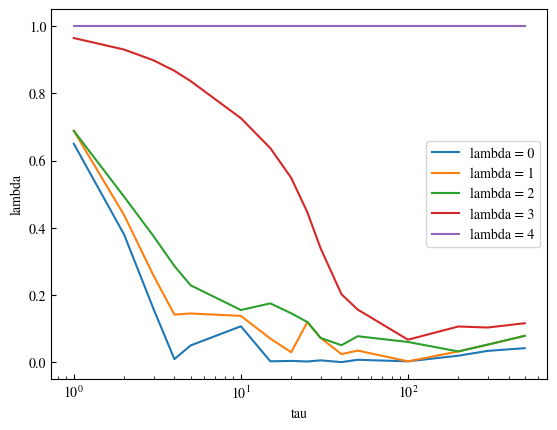

In [37]:
for i in range(min([10,eig_val.shape[0]])):
    plt.plot(taus,lambda_tau[:,i],label="lambda = "+str(i))
    plt.xscale('log')
plt.xlabel("tau")
plt.ylabel('lambda')
plt.legend()

array([[5.72225321e-01, 7.92672410e-02, 3.24432237e-01, 2.43580600e-03,
        2.16393954e-02],
       [3.45916272e-01, 4.49754902e-01, 1.85946473e-01, 1.77696078e-02,
        6.12745098e-04],
       [4.17831801e-01, 5.48767252e-02, 5.02877698e-01, 2.26335190e-02,
        1.78025679e-03],
       [6.95157353e-03, 1.16209336e-02, 5.01550903e-02, 5.90352221e-01,
        3.40920182e-01],
       [6.46829369e-02, 4.19707959e-04, 4.13189969e-03, 3.57072904e-01,
        5.73692552e-01]])

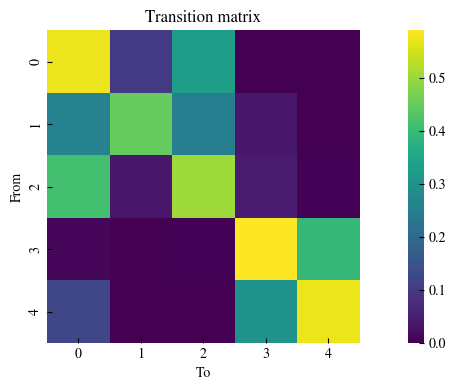

In [38]:
emb.make_transition_matrix(tau=3)
fig, axs = plt.subplots(1, 1, figsize=(10, 4))
plot_transition_matrix(emb.P, ax=axs)
#plot_distribution(emb.pi, ax=axs[1])
plt.tight_layout()
#plt.savefig('transition_matrix.svg',transparent=True,bbox_inches='tight')
emb.reversibilized_matrix()

Text(0, 0.5, 'amplitude of $v_2$')

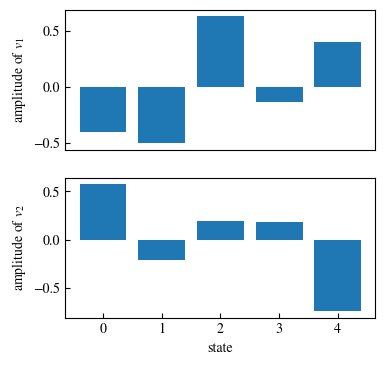

In [41]:
fig,ax = plt.subplots(figsize=(4,4),nrows=2)
# find the spectrum of the stochastic matrix
eig_val,eig_vec = np.linalg.eig(emb.P.T)
real_spectrum = np.real(eig_val)
# sort the eigen system according to the value of the real part
eig_vec = eig_vec[np.argsort(real_spectrum)]
real_spectrum = real_spectrum[np.argsort(real_spectrum)]
slow_mode = np.real(eig_vec[:,-2])
ax[0].bar(np.arange(0,slow_mode.shape[0],1),slow_mode)
ax[0].set_xticks([])
slow_mode = np.real(eig_vec[:,-3])
ax[1].bar(np.arange(0,slow_mode.shape[0],1),slow_mode)
ax[1].set_xlabel('state')
ax[0].set_ylabel(r'amplitude of $v_1$')
ax[1].set_ylabel(r'amplitude of $v_2$')
#fig.savefig('first_two_eigen_vect.svg',bbox_inches='tight')

[]

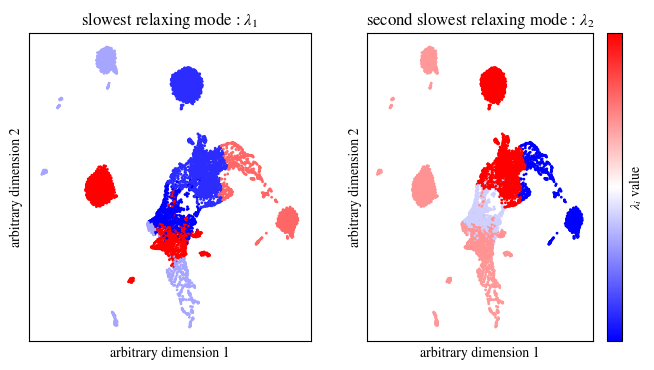

In [42]:
fig,ax = plt.subplots(ncols=2,figsize=(8,4))
slow_mode = np.real(eig_vec[:,-2])
color_values = [slow_mode[lab] for lab in emb.labels[indices]]
ax[0].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1.,rasterized=True,cmap='bwr')
#ax = use_mpl_scatter_density(fig, reduced_points[:,0],reduced_points[:,1],dpi=10,nrows=1,pos=1,colorbar=None)
#for i in range(reduced_centers.shape[0]):
#    ax.scatter(reduced_centers[i,0],reduced_centers[i,1],s=counts[i]*0.01,color="red", alpha=0.3)
    
vor = Voronoi(reduced_centers)
#voronoi_plot_2d(vor, ax=ax[0], show_points = False, show_vertices=False, line_colors='red')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('arbitrary dimension 1')
ax[0].set_ylabel('arbitrary dimension 2')
ax[0].set_title(r'slowest relaxing mode : $\lambda_1$')

slow_mode = np.real(eig_vec[:,-3])
color_values = [slow_mode[lab] for lab in emb.labels[indices]]
sc = ax[1].scatter(reduced_points[:,0],reduced_points[:,1],c = color_values,s=1.,alpha=1.,rasterized=True,cmap='bwr')
    
vor = Voronoi(reduced_centers)
#voronoi_plot_2d(vor, ax=ax[1], show_points = False, show_vertices=False, line_colors='red')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('arbitrary dimension 1')
ax[1].set_ylabel('arbitrary dimension 2')
ax[1].set_title(r'second slowest relaxing mode : $\lambda_2$')

cbar = fig.colorbar(sc, ax=ax[1])
cbar.set_label(r'$\lambda_i$ value')
cbar.ax.set_yticks([])  
#fig.savefig('umap_color_lambda.svg',transparent=True,bbox_inches='tight')

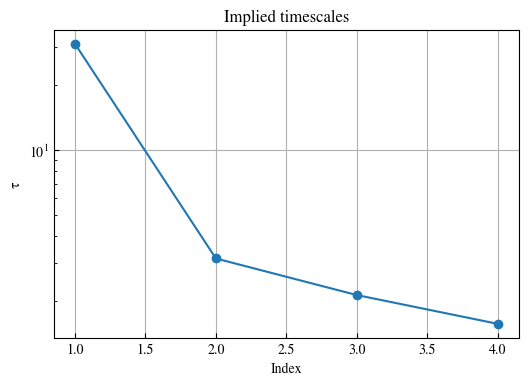

In [43]:
ts = emb.implied_timescales(emb.Pr, lag=emb.tau)

fig, ax = plt.subplots(figsize=(6, 4))
plot_implied_timescales(ts, ax=ax)
plt.yscale('log')

In [54]:
emb.make_transition_matrix(tau=1)
state_trajectory = list()
emb.initialize_state()
state_trajectory.append(emb.state)
for i in range(3):
    emb.make_transition()
    state_trajectory.append(emb.state)
state_trajectory=np.array(state_trajectory)

In [55]:
phase_trajectory = list()
for points in state_trajectory:
    phase_trajectory.append(emb.pick_random_trajectory_in_cluster(points))
phase_trajectory = np.array(phase_trajectory)

In [56]:
speed, theta,torsion = phase_trajectory.flatten()[0::3],phase_trajectory.flatten()[1::3],phase_trajectory.flatten()[2::3]
traj = reconstruct_trajectory_from_angles(np.array([speed,theta,torsion]).T)
#speed, theta,torsion = phase_trajectory.flatten()[0::2],phase_trajectory.flatten()[1::2]
#traj = reconstruct_trajectory_from_angles(np.array([speed,theta]).T)

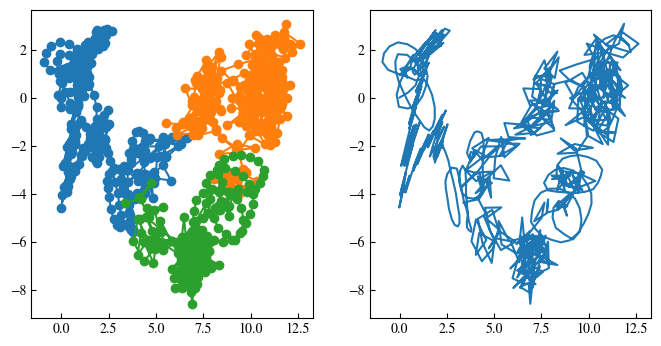

In [57]:
fig,ax = plt.subplots(ncols=2,figsize=(8,4))
tint = phase_trajectory.shape[1]//2 # phase_trajectory.shape[1] contains x and y
for i in range(phase_trajectory.shape[0]):
    ax[0].plot(traj[i*tint:(i+1)*tint,0],traj[i*tint:(i+1)*tint,1],marker='o')
ax[1].plot(traj[:,0],traj[:,1])

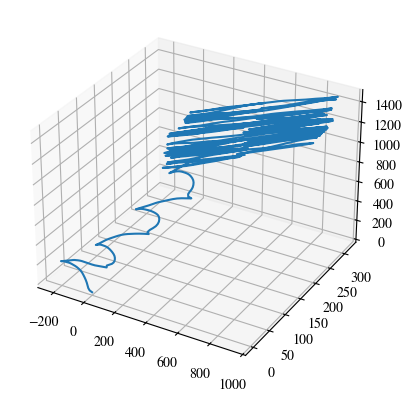

In [21]:
ax = plt.subplot(projection='3d')
ax.plot(traj[:,0],traj[:,1],traj[:,2])

In [22]:
df1 = pd.read_csv('../data/toy_model/interim/longest_trajectory.csv')
df1.head()

,x,y,z,label,frame,speed,curvature_angle,torsion_angle,abs_torsion_angle
0,3.044928,0.556233,0.122779,0,1,0.480109,0.338201,0.236234,0.236234
1,2.884539,1.021176,0.165838,0,2,0.514965,0.138686,0.576842,0.576842
2,2.642059,1.496921,0.214837,0,3,0.516911,0.115195,-0.915131,0.915131
3,2.377838,1.911421,0.292199,0,4,0.499926,0.125597,0.255416,0.255416
4,2.061311,2.297107,0.349746,0,5,0.501927,0.285208,0.237585,0.237585


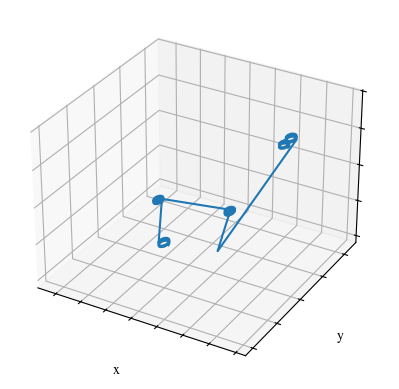

In [23]:
ax = plt.subplot(projection='3d')
ax.plot(df1['x'],df1['y'],df1['z'])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.grid(True)
plt.savefig('toy_trajectory.svg',transparent=True,bbox_inches='tight')
